# 4章 ニューラルネットワークの学習

## 4.2 損失関数

### 4.2.1 2 乗和誤差

In [1]:
import numpy as np

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.097500000000000031

In [4]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.59750000000000003

### 4.2.2 交差エントロピー誤差

交差エントロピー誤差 (cross entropy error)

$$
\begin{align}
E = -\sum_{k} t_{k}\log{y_{k}}
\end{align}
$$

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [6]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [7]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### 4.2.3 ミニバッチ学習

In [8]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [9]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### 4.2.4 [バッチ対応版]交差エントロピー誤差の実装

ミニバッチ対応 交差エントロピー誤差 (cross entropy error)

$$
\begin{align}
E = -\frac{1}{N}\sum_{n}\sum_{k} t_{nk}\log{y_{nk}}
\end{align}
$$

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [11]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

## 4.3 数値微分

### 4.3.1 微分

$$
\begin{align}
\frac{df(x)}{dx} = \lim_{h\to 0}\frac{f(x+h)-f(x)}{h}
\end{align}
$$

In [12]:
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

In [13]:
np.float32(1e-50)

0.0

In [14]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

### 4.3.2 数値微分の例

In [15]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


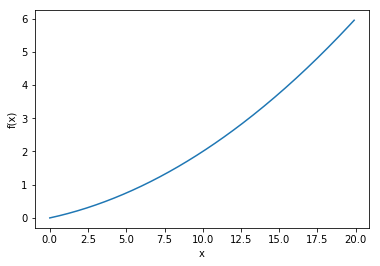

In [17]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)

In [18]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


### 4.3.3 偏微分

In [19]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [20]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [21]:
def function_tmp2(x1):
    return 3.0*2.0 + x1*x1
numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 4.4 勾配

$$
\left( \frac{\partial f}{\partial x_{0}}, \frac{\partial f}{\partial x_{1}} \right)
$$

In [48]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        print("[numerical_gradient] index for element of x : {0}".format(i))
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [23]:
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[ 6.  8.]
[ 0.  4.]
[ 6.  0.]


### 4.4.1 勾配法

$$
x_{0} = x_{0} - \eta \frac{\partial f}{\partial x_{0}}\\
x_{1} = x_{1} - \eta \frac{\partial f}{\partial x_{1}}
$$

In [24]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        
        x -= lr * grad
        
    return x

In [25]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([ -6.11110793e-10,   8.14814391e-10])

In [26]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([ -2.58983747e+13,  -1.29524862e+12])

In [27]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

### 4.4.2 ニューラルネットワークに対する勾配

$$
{\bf W} =
\begin{pmatrix}
w_{11} &w_{21} &w_{31}\\
w_{12} &w_{22} &w_{32}
\end{pmatrix}\\
\frac{\partial L}{\partial \bf W} =
\begin{pmatrix}
\frac{\partial L}{\partial w_{11}} &\frac{\partial L}{\partial w_{21}} &\frac{\partial L}{\partial w_{31}}\\
\frac{\partial L}{\partial w_{12}} &\frac{\partial L}{\partial w_{22}} &\frac{\partial L}{\partial w_{32}}
\end{pmatrix}
$$

In [28]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [29]:
net = simpleNet()
print(net.W)

[[ 0.70870208 -0.10508828 -0.53138232]
 [-0.57332673 -1.17408367 -0.3325442 ]]


In [30]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.09077281 -1.11972827 -0.61811917]


In [31]:
np.argmax(p)

0

In [32]:
t = np.array([0, 0, 1])
net.loss(x, t)

1.1939180469172155

In [33]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.30807953  0.11010148 -0.41818101]
 [ 0.4621193   0.16515222 -0.62727152]]


## 4.5 学習アルゴリズムの実装

### 4.5.1 2 層ニューラルネットワークのクラス

In [34]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

In [49]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoidi(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        print("[TwoLayerNet.numerical_gradient] calculating for W1")
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        print("[TwoLayerNet.numerical_gradient] calculating for b1")
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        print("[TwoLayerNet.numerical_gradient] calculating for W2")
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        print("[TwoLayerNet.numerical_gradient] calculating for b2")
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

In [36]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


### 4.5.2 ミニバッチ学習の実装

In [51]:
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
    
train_loss_list = []

#iters_num = 10000
iters_num = 10
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    print("[Main] iteration of main loop : {0}".format(i))
    
    print("[Main] choosing for batch ...")
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    print("[Main] calculating numerical gradient ...")
    grad = network.numerical_gradient(x_batch, t_batch)
          
    print("[Main] updating parameters ...")
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    print("[Main] calculating loss function ...")
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

[Main] iteration of main loop : 0
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 1
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 2
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 3
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 4
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 5
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating paramete

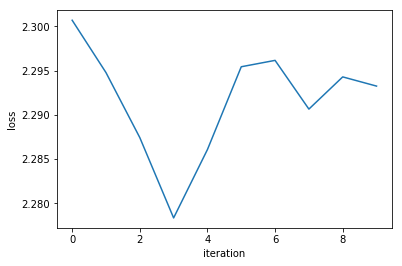

In [53]:
plt.plot(train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")

## 4.5.3 テストデータで評価

In [61]:
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
    
train_loss_list = []

#iters_num = 10000
iters_num = 100
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    print("[Main] iteration of main loop : {0}".format(i))
    
    print("[Main] choosing for batch ...")
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    print("[Main] calculating numerical gradient ...")
    grad = network.numerical_gradient(x_batch, t_batch)
    
    print("[Main] updating parameters ...")
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    print("[Main] calculating loss function ...")
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #if i % iter_per_epoch == 0:
    if i % 10 == 0:
        print("[Main] calculating accuracy ...")
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

[Main] iteration of main loop : 0
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] calculating accuracy ...
train acc, test acc | 0.0718833333333, 0.0709
[Main] iteration of main loop : 1
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 2
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 3
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 4
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 5
[Main] choosing fo

[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 46
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 47
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 48
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 49
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 50
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] calculating accuracy ...
train acc, test acc | 0.1

train acc, test acc | 0.286166666667, 0.2896
[Main] iteration of main loop : 91
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 92
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 93
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 94
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 95
[Main] choosing for batch ...
[Main] calculating numerical gradient ...
[Main] updating parameters ...
[Main] calculating loss function ...
[Main] iteration of main loop : 96
[Main] choosing for batch ...
[Main] calculat

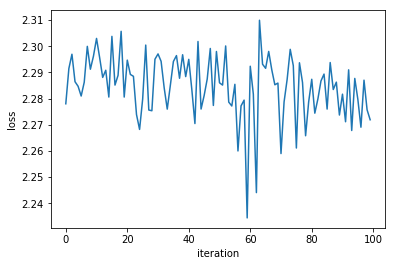

In [62]:
plt.plot(train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")

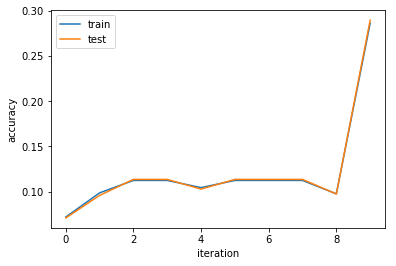

In [63]:
plt.plot(train_acc_list, label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.legend()